In [6]:
import xarray as xr
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import geopandas as gpd
import matplotlib.pyplot as plt

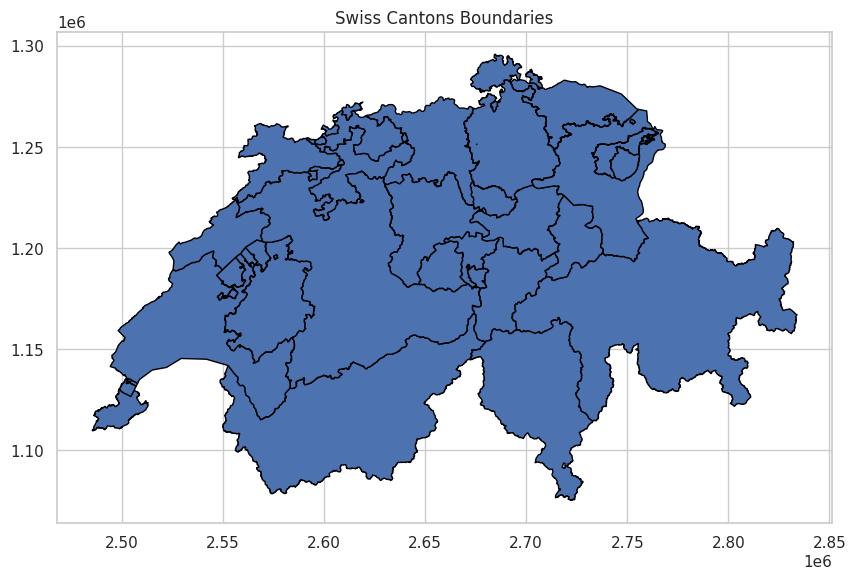

In [7]:
shp_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/Cantons_zipfile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"

gdf = gpd.read_file(shp_path)

gdf.plot(figsize=(10, 10), edgecolor='black')
plt.title("Swiss Cantons Boundaries")
plt.show()

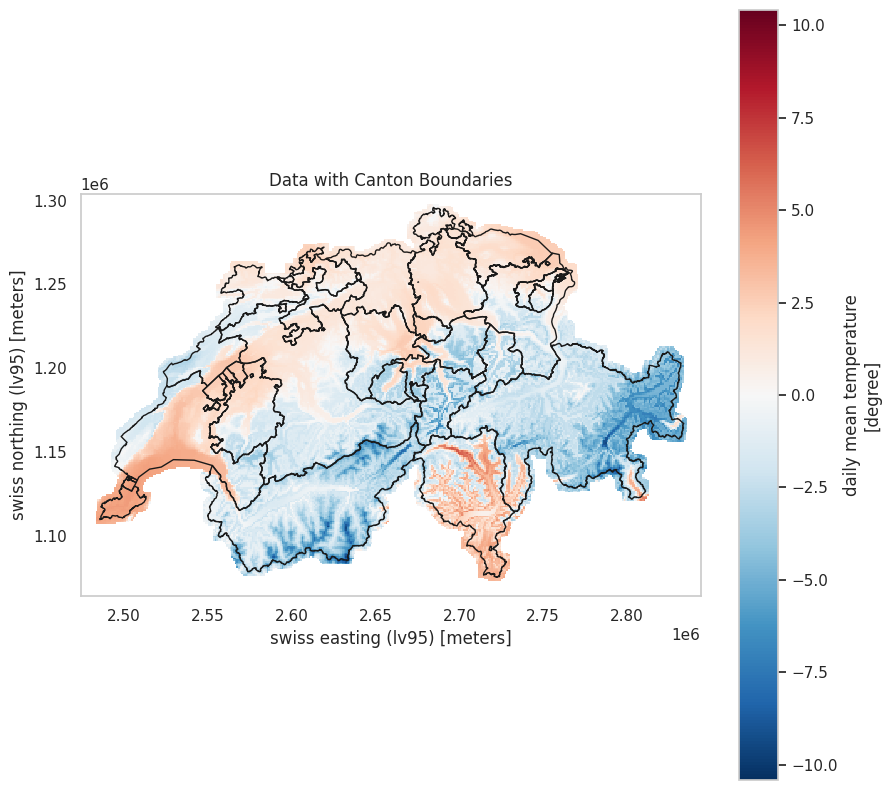

/tmp/ipykernel_3410018/2592030338.py:51: RuntimeWarning: Mean of empty slice
  means.append(np.nanmean(da_slice.values[mask]))


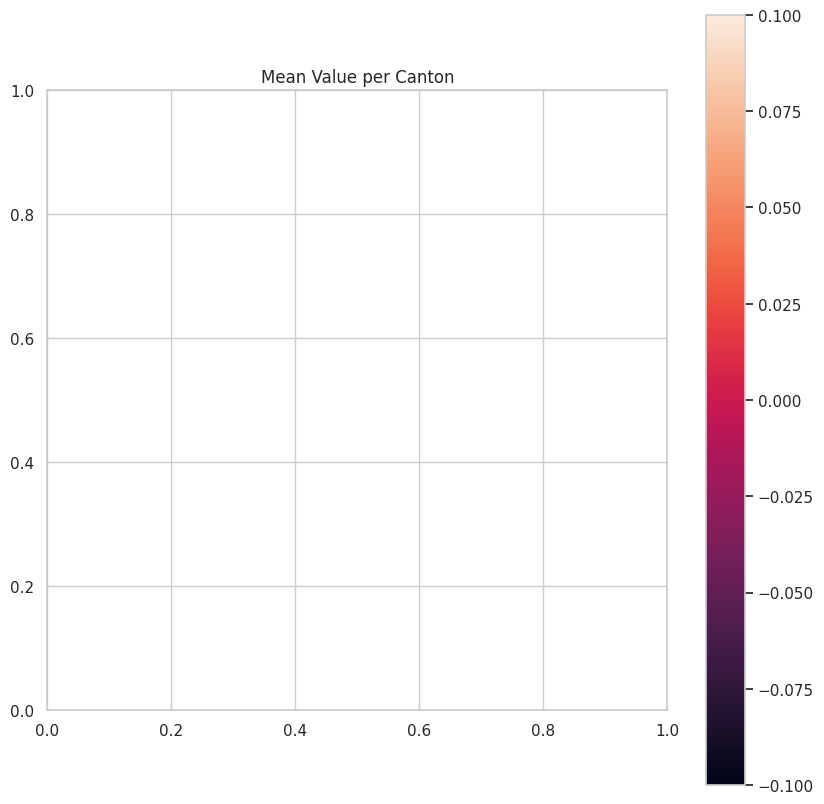

In [8]:
from rasterio import features
from affine import Affine
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

shp_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/Cantons_zipfile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"
gdf = gpd.read_file(shp_path)

ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/data_1971_2023/HR_files_full/TabsD_1971_2023.nc") 
da = ds["TabsD"]  

da_slice = da.isel(time=1800)

fig, ax = plt.subplots(figsize=(10, 10))
im = da_slice.plot(ax=ax)
gdf.boundary.plot(ax=ax, color='k', linewidth=1)
plt.title("Data with Canton Boundaries")
plt.show()

lon = da_slice['lon'].values
lat = da_slice['lat'].values

# If lat/lon are 2D, convert to 1D
if lat.ndim > 1:
    lat = lat[:, 0]
if lon.ndim > 1:
    lon = lon[0, :]

# Now you can safely check the order
if lat[1] < lat[0]:
    lat_scale = lat[1] - lat[0]
else:
    lat_scale = lat[0] - lat[1]

transform = Affine.translation(lon[0], lat[0]) * Affine.scale(lon[1]-lon[0], lat_scale)

shapes = ((geom, i) for i, geom in enumerate(gdf.geometry))
canton_mask = features.rasterize(
    shapes=shapes,
    out_shape=da_slice.shape,
    transform=transform,
    fill=-1,
    dtype=np.int16
)

means = []
for i in range(len(gdf)):
    mask = canton_mask == i
    means.append(np.nanmean(da_slice.values[mask]))

gdf["mean_value"] = means


fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="mean_value", ax=ax, legend=True, edgecolor="k")
ax.set_title("Mean Value per Canton")
fig.show()

In [2]:
#Obs
#Coarse files
# Bicubic files 
#Unet files
#LDM files

In [3]:
obs_precip=xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step1_latlon.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))

In [4]:
coarse_precip= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step2_coarse.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))

In [5]:
bicubic_precip= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step3_interp.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))

In [6]:
#unet_precip=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline.nc")["precip"].sel(time=slice("2011-01-01","2023-12-31"))

In [7]:
#ldm_precip=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")["precip"].sel(time=slice("2011-01-01","2023-12-31"))

In [10]:
# After extracting the DataArray for each city/model:
def clean_and_slice(arr):
    # arr is an xarray.DataArray
    arr = arr.sel(time=slice("2011-01-01", "2023-12-31"))
    return arr.values[~np.isnan(arr.values)]

Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 270.14
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 260.57
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.84 to 261.56
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 74.20
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 77.33
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.84 to 78.10
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 95.92
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 90.68
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.61 to 91.12
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 270.14
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 260.57
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.84 to 2

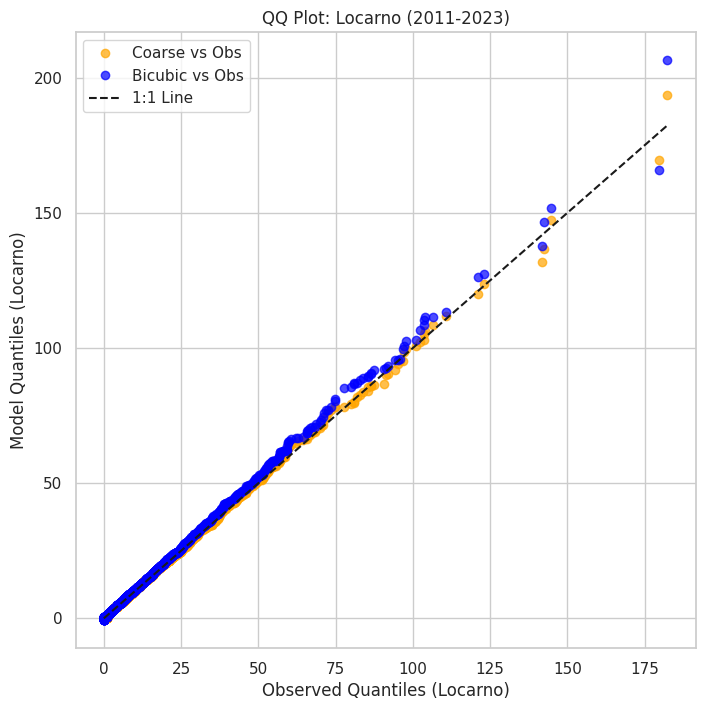

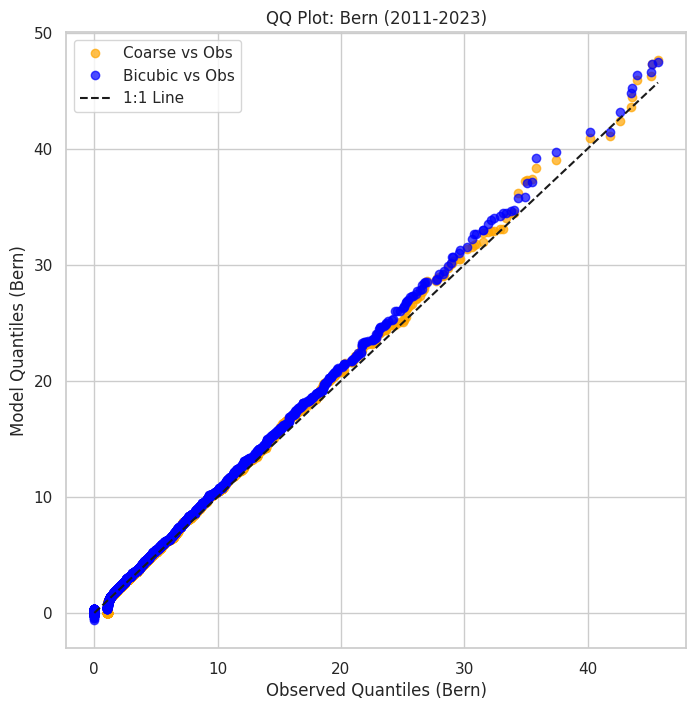

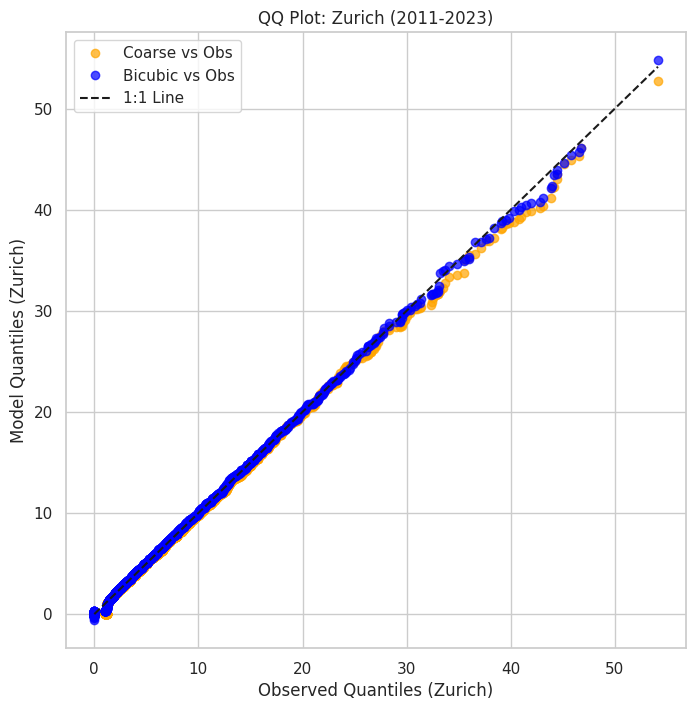

In [11]:
from closest_grid_cell import select_nearest_grid_cell

# City coordinates
locarno_lat, locarno_lon = 46.1709, 8.7995
bern_lat, bern_lon = 46.9480, 7.4474
zurich_lat, zurich_lon = 47.3769, 8.5417

# Open datasets as Dataset, not DataArray
obs_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step1_latlon.nc')
coarse_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step2_coarse.nc')
bicubic_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step3_interp.nc')
#unet_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline.nc")
#ldm_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")

# Extract time series for Locarno
obs_locarno = select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
coarse_locarno = select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
bicubic_locarno = select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
#unet_locarno = select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values
#ldm_locarno = select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values

# Extract time series for Bern
obs_bern = select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
coarse_bern = select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
bicubic_bern = select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
#unet_bern = select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'].values
#ldm_bern = select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'].values



#Extract zurich 
obs_zurich = select_nearest_grid_cell(obs_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
coarse_zurich = select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
bicubic_zurich = select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values



# Locarno
obs_locarno = clean_and_slice(select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
coarse_locarno = clean_and_slice(select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
bicubic_locarno = clean_and_slice(select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
#unet_locarno = clean_and_slice(select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'])
#ldm_locarno = clean_and_slice(select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'])

# Bern
obs_bern = clean_and_slice(select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
coarse_bern = clean_and_slice(select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
bicubic_bern = clean_and_slice(select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
#unet_bern = clean_and_slice(select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'])
#ldm_bern = clean_and_slice(select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'])


#Zurich
obs_zurich = clean_and_slice(select_nearest_grid_cell(obs_ds, zurich_lat    , zurich_lon, var_name="RhiresD")['data'])
coarse_zurich = clean_and_slice(select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'])
bicubic_zurich = clean_and_slice(select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'])


# Get common quantiles for Locarno
quantiles_locarno = np.linspace(0, 1, min(len(obs_locarno), len(coarse_locarno), len(bicubic_locarno)))
obs_q_locarno = np.quantile(obs_locarno, quantiles_locarno)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles_locarno)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles_locarno)
#unet_q_locarno = np.quantile(unet_locarno, quantiles_locarno)
#ldm_q_locarno = np.quantile(ldm_locarno, quantiles_locarno)

# Get common quantiles for Bern
quantiles_bern = np.linspace(0, 1, min(len(obs_bern), len(coarse_bern), len(bicubic_bern)))
obs_q_bern = np.quantile(obs_bern, quantiles_bern)
coarse_q_bern = np.quantile(coarse_bern, quantiles_bern)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles_bern)
#unet_q_bern = np.quantile(unet_bern, quantiles_bern)
#ldm_q_bern = np.quantile(ldm_bern, quantiles_bern)


#Common quantiles for Zurich
quantiles_zurich = np.linspace(0, 1, min(len(obs_zurich), len(coarse_zurich), len(bicubic_zurich)))
obs_q_zurich = np.quantile(obs_zurich, quantiles_zurich)
coarse_q_zurich = np.quantile(coarse_zurich, quantiles_zurich)
bicubic_q_zurich = np.quantile(bicubic_zurich, quantiles_zurich)


# Plot QQ for Locarno
plt.figure(figsize=(8, 8))
plt.plot(obs_q_locarno, coarse_q_locarno, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_locarno, bicubic_q_locarno, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
#plt.plot(obs_q_locarno, unet_q_locarno, 'o', label='UNet vs Obs', alpha=0.7)
#plt.plot(obs_q_locarno, ldm_q_locarno, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_locarno.min(), obs_q_locarno.max()], [obs_q_locarno.min(), obs_q_locarno.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Locarno)')
plt.ylabel('Model Quantiles (Locarno)')
plt.title('QQ Plot: Locarno (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Plot QQ for Bern
plt.figure(figsize=(8, 8))
plt.plot(obs_q_bern, coarse_q_bern, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_bern, bicubic_q_bern, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
#plt.plot(obs_q_bern, unet_q_bern, 'o', label='UNet vs Obs', alpha=0.7)
#plt.plot(obs_q_bern, ldm_q_bern, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_bern.min(), obs_q_bern.max()], [obs_q_bern.min(), obs_q_bern.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Bern)')
plt.ylabel('Model Quantiles (Bern)')
plt.title('QQ Plot: Bern (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()



# Plot QQ for Zurich
plt.figure(figsize=(8, 8))
plt.plot(obs_q_zurich, coarse_q_zurich, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_zurich, bicubic_q_zurich, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
plt.plot([obs_q_zurich.min(), obs_q_zurich.max()], [obs_q_zurich.min(), obs_q_zurich.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Zurich)')
plt.ylabel('Model Quantiles (Zurich)')
plt.title('QQ Plot: Zurich (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

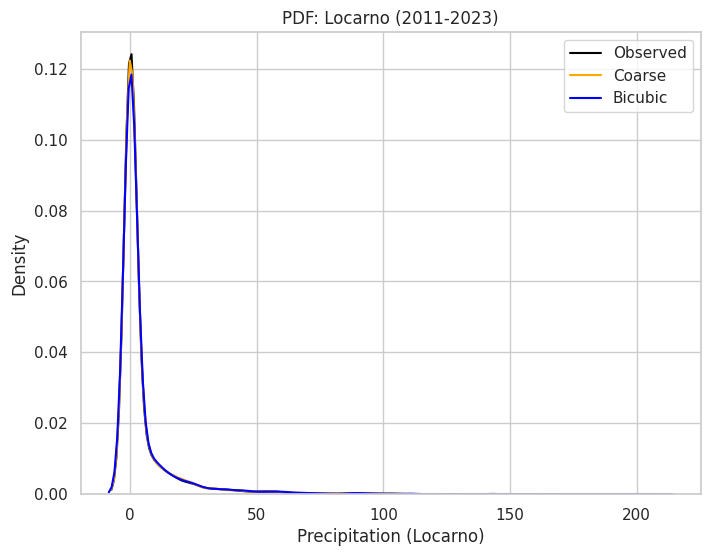

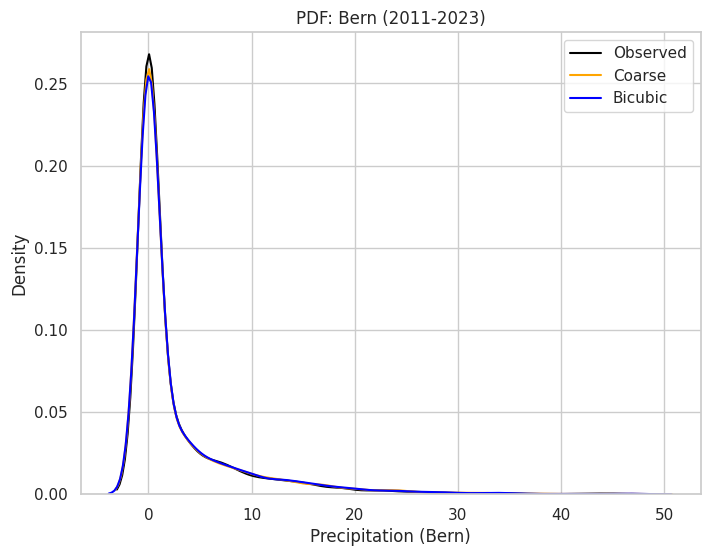

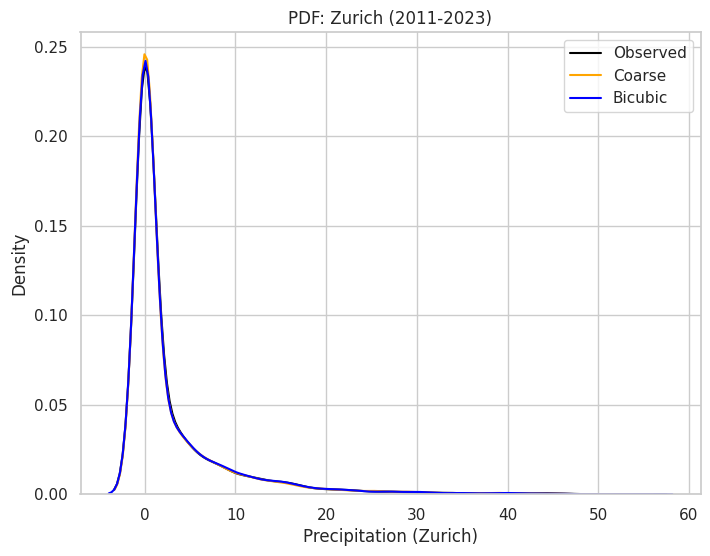

In [12]:
# Plot PDF for Locarno
plt.figure(figsize=(8, 6))
sns.kdeplot(obs_locarno, label='Observed', color='black')
sns.kdeplot(coarse_locarno, label='Coarse', color='orange')
sns.kdeplot(bicubic_locarno, label='Bicubic', color='blue')
plt.xlabel('Precipitation (Locarno)')
plt.ylabel('Density')
plt.title('PDF: Locarno (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Plot PDF for Bern
plt.figure(figsize=(8, 6))
sns.kdeplot(obs_bern, label='Observed', color='black')
sns.kdeplot(coarse_bern, label='Coarse', color='orange')
sns.kdeplot(bicubic_bern, label='Bicubic', color='blue')
plt.xlabel('Precipitation (Bern)')
plt.ylabel('Density')
plt.title('PDF: Bern (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Plot PDF for Zurich
plt.figure(figsize=(8, 6))
sns.kdeplot(obs_zurich, label='Observed', color='black')
sns.kdeplot(coarse_zurich, label='Coarse', color='orange')
sns.kdeplot(bicubic_zurich, label='Bicubic', color='blue')
plt.xlabel('Precipitation (Zurich)')
plt.ylabel('Density')
plt.title('PDF: Zurich (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -7.54 to 30.31
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -13.87 to 26.11
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -13.54 to 26.32
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.65 to 27.63
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.97 to 27.46
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.21 to 27.37
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.89 to 28.21
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.90 to 27.82
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.81 to 27.79
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -7.54 to 30.31
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -13.87 to 26.11
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -13.54 to 26.32
Variab

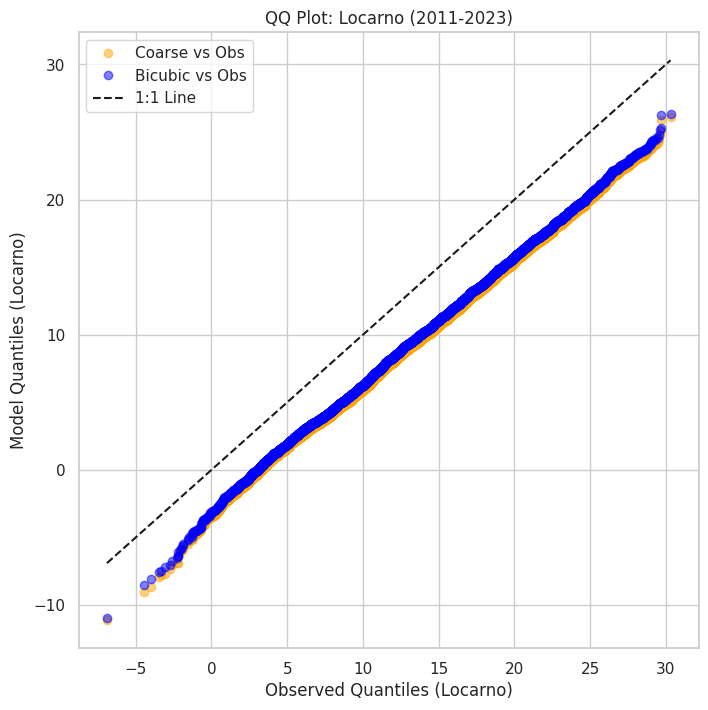

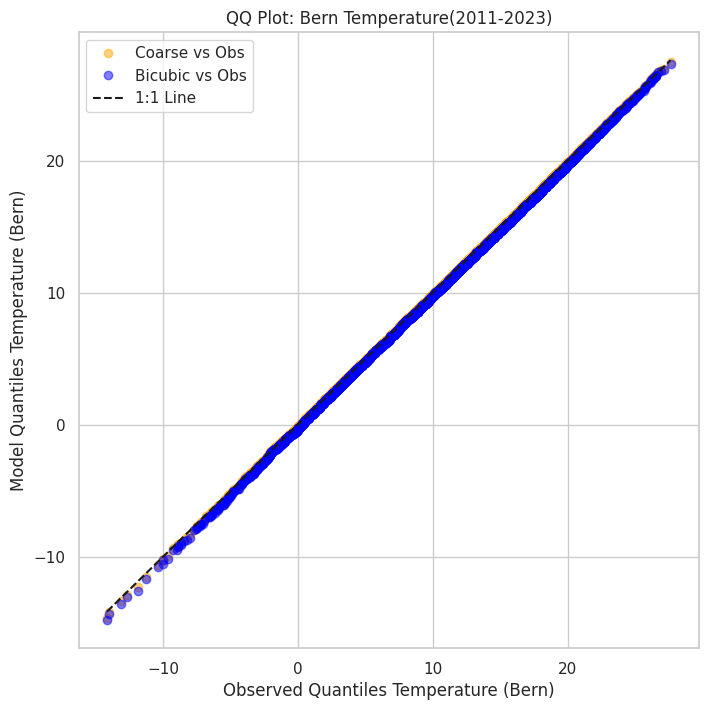

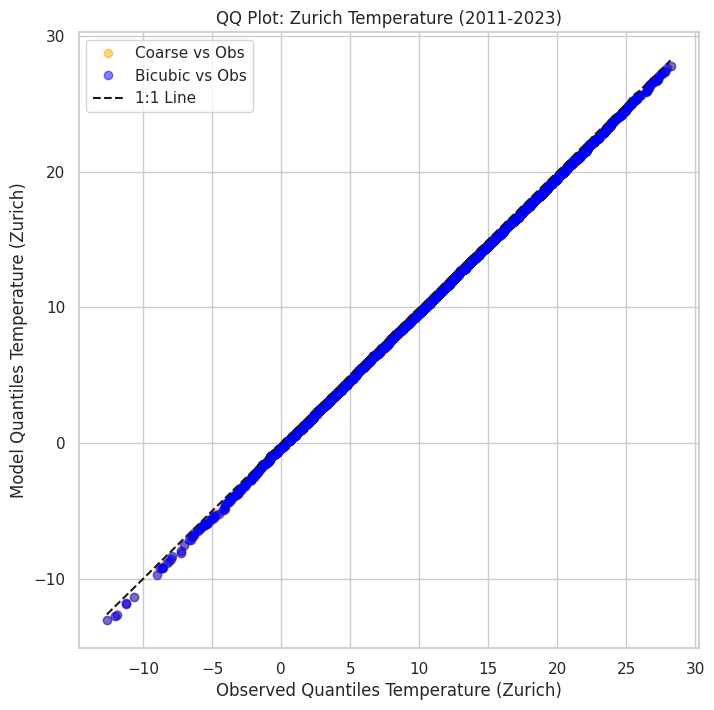

In [13]:
from closest_grid_cell import select_nearest_grid_cell
import xarray as xr 
import numpy as np
import paths


# City coordinates
locarno_lat, locarno_lon = 46.1709, 8.7995
bern_lat, bern_lon = 46.9480, 7.4474
zurich_lat, zurich_lon = 47.3769, 8.5417

# Open datasets as Dataset, not DataArray
obs_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step1_latlon.nc')
coarse_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step2_coarse.nc')
bicubic_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step3_interp.nc')
#unet_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline.nc")
#ldm_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")

# Extract time series for Locarno
obs_locarno = select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
coarse_locarno = select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
bicubic_locarno = select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
#unet_locarno = select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values
#ldm_locarno = select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values

# Extract time series for Bern
obs_bern = select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
coarse_bern = select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
bicubic_bern = select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
#unet_bern = select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'].values
#ldm_bern = select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'].values



#Extract zurich 
obs_zurich = select_nearest_grid_cell(obs_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values
coarse_zurich = select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values
bicubic_zurich = select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values



# Locarno
obs_locarno = clean_and_slice(select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
coarse_locarno = clean_and_slice(select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
bicubic_locarno = clean_and_slice(select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
#unet_locarno = clean_and_slice(select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'])
#ldm_locarno = clean_and_slice(select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'])

# Bern
obs_bern = clean_and_slice(select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
coarse_bern = clean_and_slice(select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
bicubic_bern = clean_and_slice(select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
#unet_bern = clean_and_slice(select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'])
#ldm_bern = clean_and_slice(select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'])


#Zurich
obs_zurich = clean_and_slice(select_nearest_grid_cell(obs_ds, zurich_lat    , zurich_lon, var_name="TabsD")['data'])
coarse_zurich = clean_and_slice(select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'])
bicubic_zurich = clean_and_slice(select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'])


# Get common quantiles for Locarno
quantiles_locarno = np.linspace(0, 1, min(len(obs_locarno), len(coarse_locarno), len(bicubic_locarno)))
obs_q_locarno = np.quantile(obs_locarno, quantiles_locarno)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles_locarno)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles_locarno)
#unet_q_locarno = np.quantile(unet_locarno, quantiles_locarno)
#ldm_q_locarno = np.quantile(ldm_locarno, quantiles_locarno)

# Get common quantiles for Bern
quantiles_bern = np.linspace(0, 1, min(len(obs_bern), len(coarse_bern), len(bicubic_bern)))
obs_q_bern = np.quantile(obs_bern, quantiles_bern)
coarse_q_bern = np.quantile(coarse_bern, quantiles_bern)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles_bern)
#unet_q_bern = np.quantile(unet_bern, quantiles_bern)
#ldm_q_bern = np.quantile(ldm_bern, quantiles_bern)


#Common quantiles for Zurich
quantiles_zurich = np.linspace(0, 1, min(len(obs_zurich), len(coarse_zurich), len(bicubic_zurich)))
obs_q_zurich = np.quantile(obs_zurich, quantiles_zurich)
coarse_q_zurich = np.quantile(coarse_zurich, quantiles_zurich)
bicubic_q_zurich = np.quantile(bicubic_zurich, quantiles_zurich)


# Plot QQ for Locarno
plt.figure(figsize=(8, 8))
plt.plot(obs_q_locarno, coarse_q_locarno, 'o', label='Coarse vs Obs', alpha=0.5,color='orange')
plt.plot(obs_q_locarno, bicubic_q_locarno, 'o', label='Bicubic vs Obs', alpha=0.5,color='blue')
#plt.plot(obs_q_locarno, unet_q_locarno, 'o', label='UNet vs Obs', alpha=0.7)
#plt.plot(obs_q_locarno, ldm_q_locarno, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_locarno.min(), obs_q_locarno.max()], [obs_q_locarno.min(), obs_q_locarno.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Locarno)')
plt.ylabel('Model Quantiles (Locarno)')
plt.title('QQ Plot: Locarno (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Plot QQ for Bern
plt.figure(figsize=(8, 8))
plt.plot(obs_q_bern, coarse_q_bern, 'o', label='Coarse vs Obs', alpha=0.5,color='orange')
plt.plot(obs_q_bern, bicubic_q_bern, 'o', label='Bicubic vs Obs', alpha=0.5,color='blue')
#plt.plot(obs_q_bern, unet_q_bern, 'o', label='UNet vs Obs', alpha=0.7)
#plt.plot(obs_q_bern, ldm_q_bern, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_bern.min(), obs_q_bern.max()], [obs_q_bern.min(), obs_q_bern.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles Temperature (Bern)')
plt.ylabel('Model Quantiles Temperature (Bern)')
plt.title('QQ Plot: Bern Temperature(2011-2023)')
plt.legend()
plt.grid(True)
plt.show()


# Plot QQ for Zurich
plt.figure(figsize=(8, 8))
plt.plot(obs_q_zurich, coarse_q_zurich, 'o', label='Coarse vs Obs', alpha=0.5,color='orange')
plt.plot(obs_q_zurich, bicubic_q_zurich, 'o', label='Bicubic vs Obs', alpha=0.5,color='blue')
plt.plot([obs_q_zurich.min(), obs_q_zurich.max()], [obs_q_zurich.min(), obs_q_zurich.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles Temperature (Zurich)')
plt.ylabel('Model Quantiles Temperature (Zurich)')
plt.title('QQ Plot: Zurich Temperature (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import numpy as np

In [18]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import numpy as np

mse_list = []
psnr_list = []
ssim_list = []

for t in range(obs_precip.shape[0]):
    hr_img = obs_precip.isel(time=t).values
    bicubic_img = bicubic_precip.isel(time=t).values
    if np.isnan(hr_img).any() or np.isnan(bicubic_img).any():
        mask = ~np.isnan(hr_img) & ~np.isnan(bicubic_img)
        if not np.any(mask):
            mse_list.append(np.nan)
            psnr_list.append(np.nan)
            ssim_list.append(np.nan)
            continue
        hr_img = hr_img[mask]
        bicubic_img = bicubic_img[mask]
    mse = mean_squared_error(hr_img, bicubic_img)
    psnr = peak_signal_noise_ratio(hr_img, bicubic_img, data_range=hr_img.max() - hr_img.min())
    try:
        ssim = structural_similarity(hr_img, bicubic_img, data_range=hr_img.max() - hr_img.min())
    except:
        ssim = np.nan
    mse_list.append(mse)
    psnr_list.append(psnr)
    ssim_list.append(ssim)

print("MSE (mean over time):", np.nanmean(mse_list))
print("PSNR (mean over time):", np.nanmean(psnr_list))
print("SSIM (mean over time):", np.nanmean(ssim_list))

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: invalid value encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


MSE (mean over time): 1.0934959082206164
PSNR (mean over time): 31.474414566630823
SSIM (mean over time): 0.8907776464711276


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def spatial_correlogram(field, max_lag=10):
    """Compute isotropic spatial autocorrelation as a function of lag."""
    field = field - np.nanmean(field)
    corrs = []
    for lag in range(1, max_lag+1):
        shifted_x = np.roll(field, lag, axis=1)
        shifted_y = np.roll(field, lag, axis=0)
        shifted_x[:, :lag] = np.nan
        shifted_y[:lag, :] = np.nan
        valid_x = ~np.isnan(field) & ~np.isnan(shifted_x)
        valid_y = ~np.isnan(field) & ~np.isnan(shifted_y)
        corr_x = np.corrcoef(field[valid_x], shifted_x[valid_x])[0,1] if np.any(valid_x) else np.nan
        corr_y = np.corrcoef(field[valid_y], shifted_y[valid_y])[0,1] if np.any(valid_y) else np.nan
        corrs.append(np.nanmean([corr_x, corr_y]))
    return np.array(corrs)

max_lag = 15
n_time = obs_precip.shape[0]

corrs_obs = []
corrs_coarse = []
corrs_bicubic = []

for t in range(n_time):
    corrs_obs.append(spatial_correlogram(obs_precip.isel(time=t).values, max_lag=max_lag))
    corrs_coarse.append(spatial_correlogram(coarse_precip.isel(time=t).values, max_lag=max_lag))
    corrs_bicubic.append(spatial_correlogram(bicubic_precip.isel(time=t).values, max_lag=max_lag))

corrs_obs = np.nanmean(corrs_obs, axis=0)
corrs_coarse = np.nanmean(corrs_coarse, axis=0)
corrs_bicubic = np.nanmean(corrs_bicubic, axis=0)

lags = np.arange(1, max_lag+1)
plt.figure(figsize=(8,5))
plt.plot(lags, corrs_obs, label='Obs', color='black')
plt.plot(lags, corrs_coarse, label='Coarse', color='orange')
plt.plot(lags, corrs_bicubic, label='Bicubic', color='blue')
plt.xlabel('Spatial lag (grid cells)')
plt.ylabel('Mean spatial autocorrelation')
plt.title('Mean Spatial Correlogram (averaged over time)')
plt.legend()
plt.grid(True)
plt.show()